In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import os
path = "/content/drive/MyDrive/code/WZ"
os.chdir(path)
print(os.getcwd())

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/code/WZ'

In [1]:
import importlib
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import copy
from collections import deque


sizef = 8

In [2]:
class Gomoku:
    def __init__(self, size=sizef, black_strategy=None, white_strategy=None):
        self.size = size  # 棋盘大小
        self.board = [['.' for _ in range(size)] for _ in range(size)]  # 初始化棋盘
        self.current_player = 'X'  # 当前玩家 ('X' or 'O')
        self.black_strategy = black_strategy  # 黑棋策略函数
        self.white_strategy = white_strategy  # 白棋策略函数

    def display_board(self):
        """打印棋盘"""
        print("   " + " ".join(f"{i:2}" for i in range(self.size)))
        for i, row in enumerate(self.board):
            print(f"{i:2} " + " ".join(row))

    def is_valid_move(self, x, y):
        """检查落子是否合法"""
        return 0 <= x < self.size and 0 <= y < self.size and self.board[x][y] == '.'

    def make_move(self, x, y):
        """下棋"""
        if self.is_valid_move(x, y):
            self.board[x][y] = self.current_player
            return True
        else:
            print(f"Invalid move by player {self.current_player} at ({x}, {y}).")
            return False

    def check_winner(self, x, y):
        """检查当前玩家是否获胜"""
        directions = [(1, 0), (0, 1), (1, 1), (1, -1)]  # 四个方向：水平、垂直、正斜线、反斜线
        for dx, dy in directions:
            count = 1
            # 检查正方向
            for step in range(1, 5):
                nx, ny = x + step * dx, y + step * dy
                if 0 <= nx < self.size and 0 <= ny < self.size and self.board[nx][ny] == self.current_player:
                    count += 1
                else:
                    break
            # 检查反方向
            for step in range(1, 5):
                nx, ny = x - step * dx, y - step * dy
                if 0 <= nx < self.size and 0 <= ny < self.size and self.board[nx][ny] == self.current_player:
                    count += 1
                else:
                    break
            if count >= 5:  # 连续五子
                return True
        return False

    def switch_player(self):
        """切换玩家"""
        self.current_player = 'O' if self.current_player == 'X' else 'X'

    def play(self):
        """游戏主循环"""
        print("Starting Gomoku!")
        self.display_board()

        # 检查是否有 GPU 可用
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Running on device: {device}")

        while True:
            if self.current_player == 'X':
                if self.black_strategy:
                    # 将策略函数运行在指定设备上
                    move = self.black_strategy(self.board, 'X', device=device)
                else:
                    move = self.get_human_move()
            else:
                if self.white_strategy:
                    # 将策略函数运行在指定设备上
                    move = self.white_strategy(self.board, 'O', device=device)
                else:
                    move = self.get_human_move()

            if not move or len(move) != 2:
                print(f"Invalid move returned by player {self.current_player}.")
                break

            x, y = move
            if self.make_move(x, y):
                print(f"Player {self.current_player} places at ({x}, {y})")
                self.display_board()
                if self.check_winner(x, y):
                    print(f"Player {self.current_player} wins!")
                    break
                self.switch_player()
            else:
                print("Game Over due to invalid move.")
                break

        print("Game Over!")

    def get_human_move(self):
        """获取玩家的落子"""
        while True:
            try:
                move = input(f"Player {self.current_player}, enter your move (row col): ").strip()
                x, y = map(int, move.split())
                if self.is_valid_move(x, y):
                    return x, y
                else:
                    print("Invalid move. Try again.")
            except ValueError:
                print("Invalid input. Please enter row and column numbers separated by a space.")


def load_strategy(file_name):
    """从本地文件加载策略"""
    if not os.path.exists(file_name):
        raise FileNotFoundError(f"Strategy file {file_name} not found.")

    module_name = os.path.splitext(os.path.basename(file_name))[0]
    spec = importlib.util.spec_from_file_location(module_name, file_name)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    return module.play  # 假设策略文件中定义了一个 play 函数



def print_strategy_files(directory):
    try:
        for root, dirs, files in os.walk(directory):
            for file in files:
                if file.endswith("strategy.py"):
                    print(file)
    except Exception as e:
        print(f"Invaid: {e}")

In [3]:
print("Welcome to Gomoku!")
print("Choose game mode:")
print("1. Human vs AI")
print("2. AI vs AI")
mode = input("Enter 1 or 2: ").strip()

black_strategy = None
white_strategy = None

if mode == "1":
    print("You will play as 'X'.")
    print_strategy_files(os.getcwd())
    white_strategy_file = input("Enter the AI strategy file for 'O' (e.g., white_strategy.py): ").strip()
    white_strategy = load_strategy(white_strategy_file)
elif mode == "2":
    print_strategy_files(os.getcwd())
    black_strategy_file = input("Enter the AI strategy file for 'X' (e.g., black_strategy.py): ").strip()
    white_strategy_file = input("Enter the AI strategy file for 'O' (e.g., white_strategy.py): ").strip()
    black_strategy = load_strategy(black_strategy_file)
    white_strategy = load_strategy(white_strategy_file)
else:
    print("Invalid choice. Exiting.")

game = Gomoku(black_strategy=black_strategy, white_strategy=white_strategy)
game.play()

Welcome to Gomoku!
Choose game mode:
1. Human vs AI
2. AI vs AI


KeyboardInterrupt: Interrupted by user

In [7]:
from alpha0v2_strategy_v2 import AlphaZeroNet
from alpha0v2_strategy_v2 import MCTS

In [3]:
# ------------------------------
# Data Generation via Self-Play
# ------------------------------
def self_play_game(model, board_size, mcts_simulations=5):
    """Generate training data via self-play"""
    # 检查是否有 GPU 并将模型移动到 GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # 初始化棋盘和 MCTS
    board = [['.' for _ in range(board_size)] for _ in range(board_size)]
    mcts = MCTS(model, board_size)
    current_player = 'X'
    last_move = None
    game_data = []  # Store (state, policy, value) for training
    winner = None

    while True:

        # Run MCTS to get the move and actions
        move, actions = mcts.run(board, current_player, mcts_simulations, last_move=last_move)

        # Step 1: 提取所有 (action, Q + u) 对
        action_values = [(action, node.get_value(c_puct=5.0)) for action, node in actions.items()]

        # Step 2: 计算所有 (Q + u) 的 softmax 概率
        values = np.array([value for _, value in action_values])
        exp_values = np.exp(values - np.max(values))  # 稳定的 softmax 计算
        probabilities = exp_values / np.sum(exp_values)

        # Step 3: 生成结果数组
        action_probs = [(action, prob) for (action, _), prob in zip(action_values, probabilities)]
        
        state = mcts.board_to_tensor(board, current_player, last_move).squeeze(0).detach().cpu().numpy()

        # Make the move
        board = mcts.make_move(board, move, current_player)

        # Store state and policy
#         state = np.zeros((4, board_size, board_size))

#         # 当前玩家的棋子位置
#         for x in range(board_size):
#             for y in range(board_size):
#                 if board[x][y] == current_player:
#                     state[0][x][y] = 1.0
#                 elif board[x][y] != '.':  # 对手的棋子位置
#                     state[1][x][y] = 1.0

#         # 最近一次落子的位置
#         if last_move is not None:
#             state[2][last_move[0]][last_move[1]] = 1.0

#         # 当前轮到谁下棋
#         if current_player == 'O':  # 如果是偶数回合，轮到白棋
#             state[3][:, :] = 1.0

        # 更新 last_move
        last_move = move

        # 转换动作概率
        action_probs_np = np.zeros((board_size, board_size))
        for (x, y), prob in action_probs:
            action_probs_np[x, y] = prob

        # 检查胜利条件
        if mcts.check_winner(board, current_player):
            winner = current_player
            game_data.append([state, action_probs_np, 1 if winner == 'X' else -1])
            break

        # 检查平局
        if not mcts.get_legal_moves(board):
            winner = None  # Draw
            game_data.append([state, action_probs_np, 0])
            break

        # 切换玩家
        current_player = 'O' if current_player == 'X' else 'X'

    return game_data

In [4]:
def compute_softmax_probabilities(children):
    # Step 1: 提取所有 (action, value_sum) 对
    action_values = [(action, node.value_sum) for action, node in children.items()]

    # Step 2: 计算所有 value_sum 的 softmax 概率
    values = np.array([value_sum for _, value_sum in action_values])
    exp_values = np.exp(values - np.max(values))
    probabilities = exp_values / np.sum(exp_values)

    # Step 3: 生成结果数组
    result = [(action, prob) for (action, _), prob in zip(action_values, probabilities)]
    return result




In [5]:
def train_alphazero(model, white_strategy, board_size, iterations=100, games_per_iteration=10, 
                    batch_size=32, mcts_simulations=100, alpha=0.5, l2_lambda=1e-4, entropy_alpha=1e-3):
    """Train AlphaZero model"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Move model to GPU if available
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
    replay_buffer = deque(maxlen=10000)  # Replay buffer to store training data
    loss_fn_policy = nn.CrossEntropyLoss()
    loss_fn_value = nn.MSELoss()

    policy_loss_list = []
    value_loss_list = []
    results_list = [] 

    for iteration in range(iterations):
        # Generate self-play data
        for _ in range(games_per_iteration):
            game_data = self_play_game(model, board_size, mcts_simulations)
            replay_buffer.extend(game_data)
        
        # Sample a batch from replay buffer
        if len(replay_buffer) < batch_size:
            continue

        batch = random.sample(replay_buffer, batch_size)
        states, policies, values = zip(*batch)

        # Move data to GPU
        states = torch.tensor(np.stack(states), dtype=torch.float32).to(device)
        policies = torch.tensor(np.stack(policies), dtype=torch.float32).view(batch_size, 
                                                        board_size * board_size).to(device)
        values = torch.tensor(values, dtype=torch.float32).view(-1, 1).to(device)

        # Forward pass
        pred_policies, pred_values = model(states)

        # Compute losses
        policy_loss = loss_fn_policy(pred_policies, policies)
        value_loss = loss_fn_value(pred_values, values)

        l2_reg = sum(param.pow(2).sum() for param in model.parameters())
        #entropy = -torch.sum(pred_policies * torch.log(pred_policies + 1e-8), dim=1).mean()

        loss = (policy_loss * alpha + value_loss * (1 - alpha)
                + l2_lambda * l2_reg)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        policy_loss_list.append(policy_loss.item())
        value_loss_list.append(value_loss.item())

        print(f"Iteration {iteration + 1}/{iterations}")
        print(f"Policy Loss: {policy_loss.item():.4f}, Value Loss: {value_loss.item():.4f}")

        # Every 10 iterations, evaluate against pure MCTS
        if (iteration + 1) % 10 == 0:
            print(f"Starting evaluation against pure MCTS at iteration {iteration + 1}")
            model_copy = copy.deepcopy(model)
            wins, losses, ties = play_with_model_and_strategy(model_copy,
                                                              white_strategy, board_size=board_size, rounds=10)
            print("win: {}, lose: {}, tie:{}".format(wins, losses, ties))
            results_list.append((wins, losses, ties))

    # Save model weights
    torch.save(model.state_dict(), "alphazero_weights.pth")
    print("Training complete. Weights saved to 'alphazero_weights.pth'.")

    return policy_loss_list, value_loss_list, results_list



In [6]:
import torch
board_list = []
def play_with_model_and_strategy(alpha_zero_model, white_strategy, board_size=8, rounds=1):
    """
    使用 AlphaZero 模型和 white_strategy 策略进行对弈
    Args:
        alpha_zero_model: AlphaZero 模型实例
        white_strategy: 白棋的策略函数
        board_size: 棋盘大小
        rounds: 对弈的轮数
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    # 将模型移动到 GPU
    alpha_zero_model = alpha_zero_model.to(device)

    scores = {'AlphaZero': 0, 'WhiteStrategy': 0, 'Draw': 0}
    mcts = MCTS(alpha_zero_model,board_size)
    for _ in range(rounds):
        # 初始化棋盘和游戏状态
        board = [['.' for _ in range(board_size)] for _ in range(board_size)]
        current_player = 'X'  # AlphaZero 先手
        winner = None
        last_move = None

        while True:
            if current_player == 'X':  # AlphaZero 的回合
                board_tensor = mcts.board_to_tensor(board, current_player,last_move).to(device)
                best_action, _ = mcts.run(board,current_player)
                #print(best_action)
                x, y = best_action
                move = x,y
            else:  # white_strategy 的回合
                move = white_strategy(board, 'O')

                x, y = move

            # 执行落子
            if board[x][y] == '.':
                board[x][y] = current_player

                # 检查是否获胜
                if mcts.check_winner(board, current_player):
                    board_list.append(board)
                    if current_player == 'X':
                        scores['AlphaZero'] += 1
                    else:
                        scores['WhiteStrategy'] += 1
                    break

                # 切换玩家
                current_player = 'O' if current_player == 'X' else 'X'
            else:
                #scores['WhiteStrategy' if current_player == 'X' else 'AlphaZero'] += 1
                break
            last_move = move

        # 检查是否平局
        if not any('.' in row for row in board) and winner is None:

            scores['Draw'] += 1

    # 打印对弈结果

    return scores['AlphaZero'],scores['WhiteStrategy'],scores['Draw']



In [8]:
board_size = 8
model = AlphaZeroNet(board_size)
white_strategy = load_strategy('./mctsv2_strategy.py')

policy_loss, value_loss, results_list = train_alphazero(
                        model=model,
                        white_strategy = white_strategy,
                        board_size=board_size,
                        iterations=800,
                        games_per_iteration=5,
                        batch_size=16,
                        mcts_simulations=50,
                        alpha=0.5,
                        l2_lambda=0)

Using device: cpu
Iteration 4/800
Policy Loss: 4.2169, Value Loss: 1.1306
Iteration 5/800
Policy Loss: 4.1832, Value Loss: 1.0171
Iteration 6/800
Policy Loss: 4.1603, Value Loss: 0.7339
Iteration 7/800
Policy Loss: 4.1284, Value Loss: 0.5369
Iteration 8/800
Policy Loss: 4.0972, Value Loss: 0.8261
Iteration 9/800
Policy Loss: 3.8171, Value Loss: 0.8624
Iteration 10/800
Policy Loss: 3.7120, Value Loss: 0.9876
Starting evaluation against pure MCTS at iteration 10
win: 0, lose: 10, tie:0
Iteration 11/800
Policy Loss: 3.5984, Value Loss: 0.9600
Iteration 12/800
Policy Loss: 3.6498, Value Loss: 0.3154
Iteration 13/800
Policy Loss: 2.9102, Value Loss: 0.4001
Iteration 14/800
Policy Loss: 3.9201, Value Loss: 0.2384
Iteration 15/800
Policy Loss: 3.3819, Value Loss: 0.4497
Iteration 16/800
Policy Loss: 3.1947, Value Loss: 0.5074
Iteration 17/800
Policy Loss: 3.9347, Value Loss: 0.3945
Iteration 18/800
Policy Loss: 3.5925, Value Loss: 0.2851
Iteration 19/800
Policy Loss: 3.2980, Value Loss: 0.194

win: 7, lose: 3, tie:0
Iteration 131/800
Policy Loss: 0.7628, Value Loss: 0.0000
Iteration 132/800
Policy Loss: 0.1655, Value Loss: 0.0012
Iteration 133/800
Policy Loss: 0.3287, Value Loss: 0.0000
Iteration 134/800
Policy Loss: 0.5364, Value Loss: 0.0000
Iteration 135/800
Policy Loss: 0.4540, Value Loss: 0.0038
Iteration 136/800
Policy Loss: 0.2450, Value Loss: 0.0000
Iteration 137/800
Policy Loss: 0.2495, Value Loss: 0.0000
Iteration 138/800
Policy Loss: 0.1996, Value Loss: 0.0000
Iteration 139/800
Policy Loss: 0.0180, Value Loss: 0.0000
Iteration 140/800
Policy Loss: 0.3464, Value Loss: 0.0000
Starting evaluation against pure MCTS at iteration 140
win: 4, lose: 6, tie:0
Iteration 141/800
Policy Loss: 0.2599, Value Loss: 0.0001
Iteration 142/800
Policy Loss: 0.1412, Value Loss: 0.0132
Iteration 143/800
Policy Loss: 0.0542, Value Loss: 0.0000
Iteration 144/800
Policy Loss: 0.0979, Value Loss: 0.0000
Iteration 145/800
Policy Loss: 0.1877, Value Loss: 0.0000
Iteration 146/800
Policy Loss

Iteration 256/800
Policy Loss: 0.0004, Value Loss: 0.0000
Iteration 257/800
Policy Loss: 0.0003, Value Loss: 0.0000
Iteration 258/800
Policy Loss: 0.0005, Value Loss: 0.0000
Iteration 259/800
Policy Loss: 0.0003, Value Loss: 0.0000
Iteration 260/800
Policy Loss: 0.0004, Value Loss: 0.0000
Starting evaluation against pure MCTS at iteration 260
win: 5, lose: 5, tie:0
Iteration 261/800
Policy Loss: 0.0003, Value Loss: 0.0000
Iteration 262/800
Policy Loss: 0.0002, Value Loss: 0.0000
Iteration 263/800
Policy Loss: 0.0003, Value Loss: 0.0000
Iteration 264/800
Policy Loss: 0.0003, Value Loss: 0.0000
Iteration 265/800
Policy Loss: 0.0011, Value Loss: 0.0000
Iteration 266/800
Policy Loss: 0.0003, Value Loss: 0.0000
Iteration 267/800
Policy Loss: 0.0004, Value Loss: 0.0000
Iteration 268/800
Policy Loss: 0.0004, Value Loss: 0.0000
Iteration 269/800
Policy Loss: 0.0002, Value Loss: 0.0000
Iteration 270/800
Policy Loss: 0.0004, Value Loss: 0.0000
Starting evaluation against pure MCTS at iteration 2

KeyboardInterrupt: 

In [9]:
board_size = 7
rounds = 10  # 对弈的轮数
weights_path = "./weights/alphazero_weights.pth"  # AlphaZero 模型权重文件路径
#weights_path = "./weights_v2/size8_win5"  # AlphaZero 模型权重文件路径

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 定义 white_strategy，使用简单的随机策略
white_strategy = load_strategy('./mctsv2_strategy.py')


model = AlphaZeroNet(board_size)

# 获取模型的 state_dict


try:
    model.load_state_dict(torch.load(weights_path, map_location=device))
except:
    state_dict = model.state_dict()
# 将权重从 list 转换为 PyTorch 张量并加载到模型
    for (name, param), weight in zip(state_dict.items(), policy_param):
        print(f"Loading {name} with shape {weight.shape}")
        if "weight" in name and param.shape != torch.tensor(weight).shape:
            weight = weight.T  # 转置权重
        state_dict[name] = torch.tensor(weight, dtype=param.dtype)

# 加载更新后的 state_dict 到模型
    model.load_state_dict(state_dict)

print("Model weights loaded successfully!")


model = model.to(device)
model.eval()

# 开始对弈
print(f"Starting {rounds} rounds of matches...")
alpha_zero_wins, white_strategy_wins, draws = play_with_model_and_strategy(
    model,
    white_strategy,
    board_size=board_size,
    rounds=rounds,
)

print("win: {}, lose: {}, tie:{}".format(alpha_zero_wins, white_strategy_wins, draws))

Model weights loaded successfully!
Starting 10 rounds of matches...


KeyboardInterrupt: 

In [13]:
board_size = 7
rounds = 10  # 对弈的轮数
weights_path = "./weights/alphazero_weights.pth"  # AlphaZero 模型权重文件路径
#weights_path = "./weights_v2/size8_win5"  # AlphaZero 模型权重文件路径

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 定义 white_strategy，使用简单的随机策略
white_strategy = load_strategy('./mcts_strategy.py')


model = AlphaZeroNet(board_size)

# 获取模型的 state_dict


try:
    model.load_state_dict(torch.load(weights_path, map_location=device))
except:
    state_dict = model.state_dict()
# 将权重从 list 转换为 PyTorch 张量并加载到模型
    for (name, param), weight in zip(state_dict.items(), policy_param):
        print(f"Loading {name} with shape {weight.shape}")
        if "weight" in name and param.shape != torch.tensor(weight).shape:
            weight = weight.T  # 转置权重
        state_dict[name] = torch.tensor(weight, dtype=param.dtype)

# 加载更新后的 state_dict 到模型
    model.load_state_dict(state_dict)

print("Model weights loaded successfully!")


model = model.to(device)
model.eval()

# 开始对弈
print(f"Starting {rounds} rounds of matches...")
alpha_zero_wins, white_strategy_wins, draws = play_with_model_and_strategy(
    model,
    white_strategy,
    board_size=board_size,
    rounds=rounds,
)

print("win: {}, lose: {}, tie:{}".format(alpha_zero_wins, white_strategy_wins, draws))

Model weights loaded successfully!
Starting 10 rounds of matches...
win: 6, lose: 4, tie:0


In [64]:
import turtle

def draw_board(size, cell_size):
    """绘制棋盘"""
    turtle.speed(0)
    turtle.penup()
    turtle.hideturtle()
    turtle.bgcolor("saddlebrown")  # 棋盘底色设置为咖啡色

    # 画棋盘网格线
    for i in range(size):
        # 画水平线
        turtle.goto(-size * cell_size / 2, size * cell_size / 2 - i * cell_size)
        turtle.pendown()
        turtle.forward((size - 1) * cell_size)
        turtle.penup()
        # 画垂直线
        turtle.goto(-size * cell_size / 2 + i * cell_size, size * cell_size / 2)
        turtle.setheading(-90)
        turtle.pendown()
        turtle.forward((size - 1) * cell_size)
        turtle.penup()
        turtle.setheading(0)

def draw_X(x, y, cell_size):
    """在指定位置绘制黑色棋子"""
    turtle.penup()
    turtle.goto(x * cell_size - cell_size / 2, y * cell_size - cell_size / 2)
    turtle.dot(cell_size * 0.6, "black")  # 棋子大小为格子的60%

def draw_O(x, y, cell_size):
    """在指定位置绘制白色棋子"""
    turtle.penup()
    turtle.goto(x * cell_size - cell_size / 2, y * cell_size - cell_size / 2)
    turtle.dot(cell_size * 0.6, "white")  # 棋子大小为格子的60%

def visualize_board(board):
    """
    根据棋盘状态绘制棋盘和棋子
    Args:
        board: 棋盘，二维列表，'.'为空，'X'为黑棋，'O'为白棋
    """
    size = len(board)
    cell_size = 50  # 每个格子的大小

    # 设置窗口大小
    turtle.setup(width=size * cell_size + 100, height=size * cell_size + 100)
    turtle.setworldcoordinates(-(size - 1) / 2 * cell_size, 
                                -(size - 1) / 2 * cell_size,
                                (size + 1) / 2 * cell_size,
                                (size + 1) / 2 * cell_size)

    # 绘制棋盘
    draw_board(size, cell_size)

    # 绘制棋子
    for y, row in enumerate(board):
        for x, cell in enumerate(row):
            # x 和 y 的位置调整，以棋盘格点交叉点为基准
            x_pos = x - (size - 1) / 2
            y_pos = (size - 1) / 2 - y
            if cell == 'X':
                draw_X(x_pos, y_pos, cell_size)
            elif cell == 'O':
                draw_O(x_pos, y_pos, cell_size)

    # 添加鼠标点击退出功能
    turtle.onscreenclick(lambda x, y: turtle.bye())

    # 进入主循环
    turtle.done()

In [65]:
visualize_board(board_list[-5])

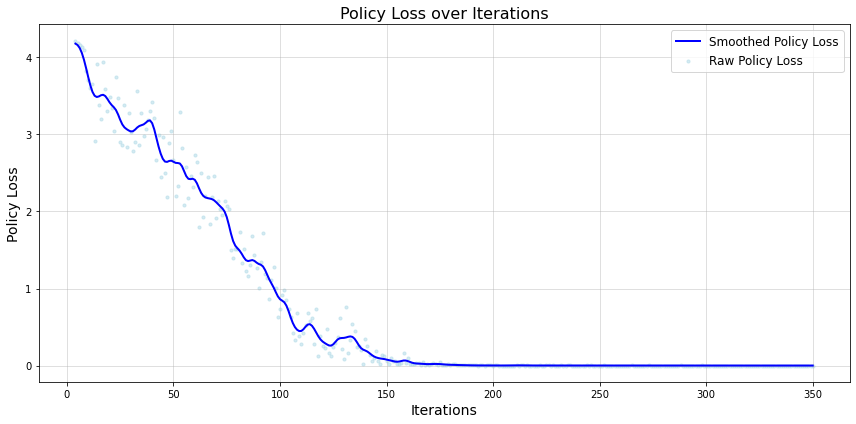

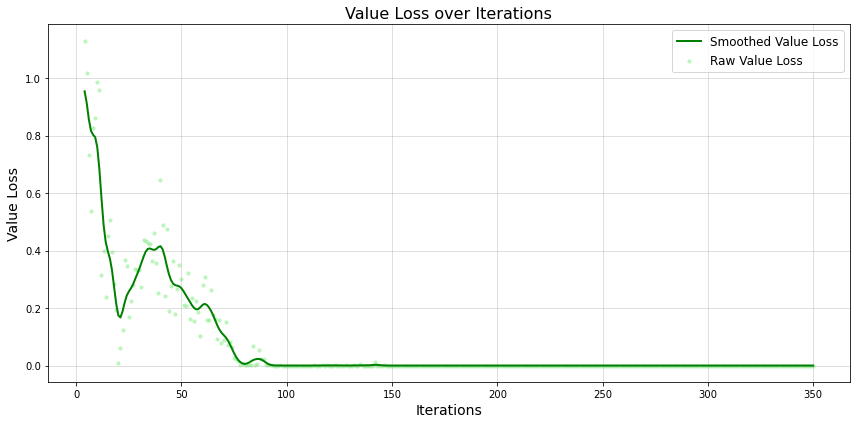

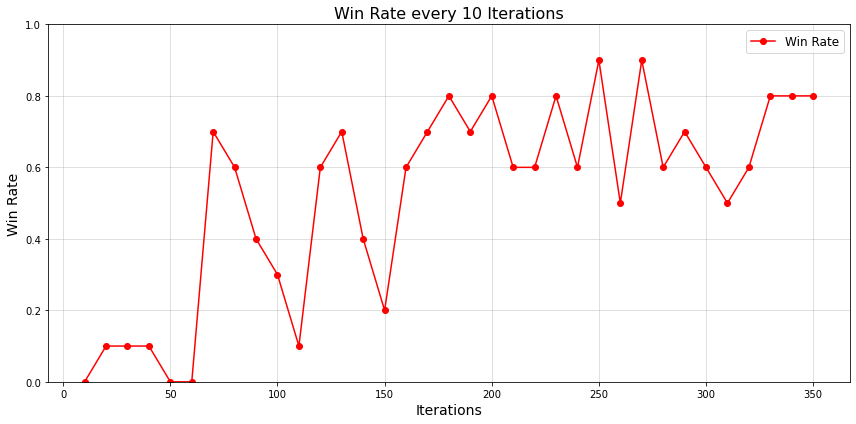

In [13]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# 解析文件，读取 iteration, policy_loss, value_loss, 以及 win_rate
iterations = []
policy_loss = []
value_loss = []
win_rates = []

file_path = 'data.txt'  # 替换为你的数据文件路径

with open(file_path, 'r', encoding='utf-8') as f:
    current_iteration = None
    for line in f:
        line = line.strip()
        # 检测 Iteration 行
        if line.startswith("Iteration"):
            # "Iteration X/800"
            parts = line.split()
            iter_part = parts[1]  # "X/800"
            current_iteration = int(iter_part.split('/')[0])

        # 检测 Policy Loss 行
        elif line.startswith("Policy Loss:"):
            # "Policy Loss: 4.2169, Value Loss: 1.1306"
            parts = line.split(',')
            policy_part = parts[0].split(':')[-1].strip()  # "4.2169"
            value_part = parts[1].split(':')[-1].strip()   # "1.1306"
            p_loss = float(policy_part)
            v_loss = float(value_part)

            if current_iteration is not None:
                iterations.append(current_iteration)
                policy_loss.append(p_loss)
                value_loss.append(v_loss)

        # 检测 win lose tie 行 (每10个iteration后的evaluation结果)
        elif line.startswith("win:"):
            # "win: 0, lose: 10, tie:0"
            parts = line.replace(' ', '').split(',')
            w = int(parts[0].split(':')[-1])
            l = int(parts[1].split(':')[-1])
            t = int(parts[2].split(':')[-1])

            total = w + l + t
            w_rate = w / total if total > 0 else 0.0
            win_rates.append(w_rate)

# 平滑处理
smoothed_policy_loss = gaussian_filter1d(policy_loss, sigma=2)
smoothed_value_loss = gaussian_filter1d(value_loss, sigma=2)

# 绘制 Policy Loss
plt.figure(figsize=(12, 6))
plt.plot(iterations, smoothed_policy_loss, label='Smoothed Policy Loss', color='blue', linewidth=2)
plt.scatter(iterations, policy_loss, label='Raw Policy Loss', color='lightblue', s=10, alpha=0.5)
plt.title('Policy Loss over Iterations', fontsize=16)
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('Policy Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

# 绘制 Value Loss
plt.figure(figsize=(12, 6))
plt.plot(iterations, smoothed_value_loss, label='Smoothed Value Loss', color='green', linewidth=2)
plt.scatter(iterations, value_loss, label='Raw Value Loss', color='lightgreen', s=10, alpha=0.5)
plt.title('Value Loss over Iterations', fontsize=16)
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('Value Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

# 绘制 Win Rate（win_rates 对应的是每10个iteration一次评估）
# 假设 win_rates 第一条对应的是 iteration=10，第二条对应 iteration=20，以此类推
winrate_iterations = [10 * (i+1) for i in range(len(win_rates))]

plt.figure(figsize=(12, 6))
plt.plot(winrate_iterations, win_rates, marker='o', color='red', label='Win Rate')
plt.title('Win Rate every 10 Iterations', fontsize=16)
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('Win Rate', fontsize=14)
plt.grid(alpha=0.5)
plt.legend(fontsize=12)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [12]:
win_rates

[0.0,
 0.1,
 0.1,
 0.1,
 0.0,
 0.0,
 0.7,
 0.6,
 0.4,
 0.3,
 0.1,
 0.6,
 0.7,
 0.4,
 0.2,
 0.6,
 0.7,
 0.8,
 0.7,
 0.8,
 0.6,
 0.6,
 0.8,
 0.6,
 0.9,
 0.5,
 0.9,
 0.6,
 0.7,
 0.6,
 0.5,
 0.6,
 0.8,
 0.8,
 0.8]